# Llama.cpp Benchmarking

##### This notebook generates plots based on the logged results, which provide data on how long it takes to generate a single token given an existing sequence length

---
### Configuration

If necessary, run the following bash commands to install LaTeX fonts and relevant packages.

In [1]:
# %%sh
# sudo apt install -y fonts-cmu texlive-latex-extra cm-super dvipng > /dev/null 2>&1
# pip install matplotlib numpy seaborn --quiet

Import relevant modules and packages and configure them appropriately.

In [2]:
from dataclasses import dataclass

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


sns.set_context("paper", font_scale=1.5)
matplotlib.rc('font', **{'family': 'serif', 'serif': ["CMU Serif"]})
matplotlib.rc('text', usetex=True)
matplotlib.font_manager.findfont("CMU Serif", rebuild_if_missing=True)

findfont: Font family ['CMU Serif'] not found. Falling back to DejaVu Sans.


'/nethome/lukehg/efficient-transformer-inference/research-llm-inference/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'

Define the hardware configurations.

In [3]:
@dataclass
class HardwareSpecification:
    bytes_per_second: int
    flops_per_second: int
    capacity: int


HARDWARE = {
    "A10": HardwareSpecification(
        bytes_per_second=600e9, 
        flops_per_second=125e12, 
        capacity=24e9,
    ),
    "A100": HardwareSpecification(
        bytes_per_second=156e10, 
        flops_per_second=312e12, 
        capacity=40e9,
    ),
}

Define the model configurations.

In [4]:
@dataclass
class ModelSpecification:
    bytes_per_parameter: int
    bytes_per_cache_element: int
    hidden_dimension: int
    kv_group_size: int
    num_layers: int
    vocab_size: int
    

MODELS = {
    "Llama-2-7B": ModelSpecification(
        bytes_per_parameter=2,
        bytes_per_cache_element=2,
        hidden_dimension=4096,
        kv_group_size=1,
        num_layers=32,
        vocab_size=32000,
    ),
    "Llama-2-7B Q8_0": ModelSpecification(
        bytes_per_parameter=1,
        bytes_per_cache_element=2,
        hidden_dimension=4096,
        kv_group_size=1,
        num_layers=32,
        vocab_size=32000,
    ),
}

---
### Functions

The `load_results` function below loads a specified `.txt` file and extracts the data into a dictionary.

In [5]:
def load_results(filename: str, log_directory=".") -> dict:

    results = {}
    with open(f"{log_directory}/{filename}.txt", "r") as file:
        for line in file.readlines():
            time = float(line.split(": ")[-1])
            sequence = int(line.split(": ")[0].split(" ")[-1])
            results[sequence] = results.get(sequence, []) + [time]
            
    return results

The `truncate` function below removes the fastest and slowest times for each sequence length, either as an absolute number, or as a proportion of the available data points.

In [6]:
def truncate(results: dict, remove_num: int = None, remove_prop: float = None) -> dict:

    assert remove_num is None or remove_prop is None
    assert remove_num is not None or remove_prop is not None

    truncated_results = {}
    for sequence, times in results.items():
        if remove_num is None:
            remove_num = len(times) * remove_prop
        remove_id = int(remove_num // 2)
        truncated_results[sequence] = sorted(times)[remove_id:-remove_id]

    return truncated_results

The `linear_regression` function below finds the line of best fit (LOBF) given the data points provided. Additionally, it extrapolates relevant information from this LOBF, including the function to calculate new data points, the equation as a string, samples based on specified sequence lengths, the `y`-intercept, and the gradient of the line.

In [7]:
def linear_regression(results: dict, sequences: list = None) -> dict:

    data = [(sequence, time) for sequence, times in results.items() for time in times]
    line_of_best_fit = np.poly1d(np.polyfit(*zip(*data), 1))

    if sequences is None:
        sequences = range(max(results.keys()))

    return {
        "function": line_of_best_fit,
        "equation": str(line_of_best_fit)[2:].replace("x", "$S$"),
        "samples": {sequence: [line_of_best_fit(sequence)] for sequence in sequences},
        "intercept": line_of_best_fit(0),
        "gradient": line_of_best_fit(1) - line_of_best_fit(0),
    }

The `attention_proportion` function below estimates how long is spent in attention (as a percentage), by noting that if the linear regression model is assumed to accurate, then the y-intercept corresponds to how long is spent doing non-attention (fixed cost) operations and transfers, and time above that is the result of the operations and transfers associated with attention. 

In [8]:
def attention_proportion(results: dict, intercept: float) -> dict:

    proportions = {}
    for sequence, times in results.items():
        for time in times:
            proportion = 100 * (time - intercept) / time
            proportions[sequence] = proportions.get(sequence, []) + [proportion]
    
    return proportions

The `get_attention_properties` function below determines the number of FLOPs and memory transfers carried out in attention for a single transformer generation step.

In [9]:
def get_attention_properties(spec: ModelSpecification, batch_size: int, sequence_length: int) -> dict:

    num_kv_groups = spec.hidden_dimension // spec.kv_group_size
    num_kv_elements = 2 * sequence_length * num_kv_groups * spec.num_layers

    flops = 2 * batch_size * spec.kv_group_size * num_kv_elements
    bytes = spec.bytes_per_cache_element * num_kv_elements

    return {"FLOPs": flops, "bytes": bytes}

The `get_transformer_properties` function below determines the number of FLOPs and memory transfers carried out in a single transformer generation step.

In [10]:
def get_transformer_properties(spec: ModelSpecification, batch_size: int, sequence_length: int) -> dict:

    attention_properties = get_attention_properties(spec, batch_size, sequence_length)

    num_embedding_parameters = spec.hidden_dimension * spec.vocab_size
    num_transformer_parameters = 12 * spec.num_layers * spec.hidden_dimension ** 2
    
    flop_parameters = num_embedding_parameters + num_transformer_parameters
    total_parameters = 2 * num_embedding_parameters + num_transformer_parameters

    flops = 2 * batch_size * flop_parameters + attention_properties["FLOPs"]
    bytes = spec.bytes_per_parameter * total_parameters + attention_properties["bytes"]

    return {"FLOPs": flops, "bytes": bytes}

---
### Plotting Tools

The `plot_data` function below provides a generic plotting tool for visualizing both absolute time spent generating a single token and the proportion of time spent in attention.

In [11]:
def plot_data(
    results: dict, 
    color: str, 
    label: str,
    scatter: bool = True,
    linestyle: bool = "solid",
    **plt_config,
) -> None:

    means, bounds = {}, {}
    for sequence, times in sorted(results.items()):
        mean, stdv = np.mean(times), np.std(times)
        means[sequence], bounds[sequence] = mean, (mean - stdv, mean + stdv)

    fill_kwargs = {"color": color, "linewidth": 0, "alpha": 0.4}
    plot_kwargs = {"color": color, "linewidth": 2, "linestyle": linestyle}
    plt.fill_between(means.keys(), *zip(*bounds.values()), **fill_kwargs)
    if scatter:
        plt.plot(*zip(*means.items()), **plot_kwargs)
        plt.scatter(*zip(*means.items()), color=color, label=label, s=32)
    else:
        plt.plot(*zip(*means.items()), label=label, **plot_kwargs)

    plt.legend(frameon=False)
    for attribute, value in plt_config.items():
        if type(value) == tuple:
            getattr(plt, attribute)(value[0], **value[1])
        else:
            getattr(plt, attribute)(value)

    sns.despine()

The `plot_data_with_configs` function defined below allows default `plt_config` configurations from specialized plotter functions (such as `plot_generation_time` and `plot_attention_proportion` as defined later in the notebook) to be used - although all values can be overridden when calling those specialized plotter functions.

In [12]:
def plot_data_with_configs(
    results: dict,
    color: str,
    label: str,
    plt_config: dict,
    **default_config,
) -> None:

    for attribute, value in default_config.items():
        plt_config[attribute] = plt_config.get(attribute, None) or value

    plot_data(results=results, color=color, label=label, **plt_config)

The `plot_generation_time` function below is a specialized plotter function, whose default setup presents a plot as comparing the time to generate a single token with a given sequence length $S$.

In [13]:
def plot_generation_time(results: dict, color: str, label: str, **plt_config) -> None:

    plot_data_with_configs(
        results=results, 
        color=color, 
        label=label, 
        plt_config=plt_config,
        # grid=(True, {"zorder": 0.5}),
        xlabel=("Sequence Length ($S$)", {"fontsize": 16}),
        ylabel=("Time to Generate Token (seconds)", {"fontsize": 16}),
    )

The `plot_attention_proportion` function below is a specialized plotter function, whose default setup presents a plot comparing the proportion of time spent in attention with a given sequence length $S$.

In [14]:
def plot_attention_proportion(results: dict, color: str, label: str, **plt_config) -> None:

    plot_data_with_configs(
        results=results, 
        color=color, 
        label=label, 
        plt_config=plt_config,
        # grid=(True, {"zorder": 0.5}),
        xlabel=("Sequence Length ($S$)", {"fontsize": 16}),
        ylabel=("Proportion of Time in Attention (\%)", {"fontsize": 16}),
    )

---
### Results

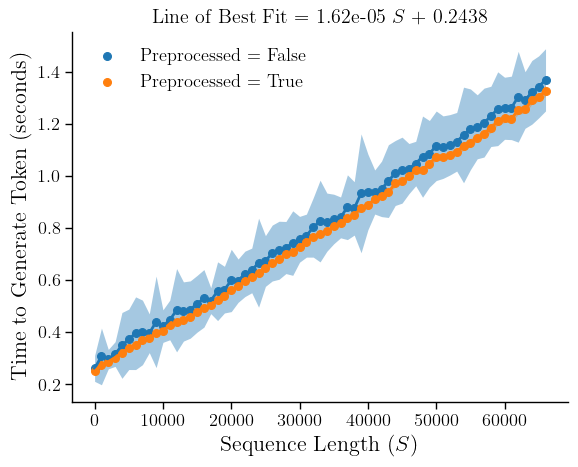

In [15]:
results = load_results("a100-kv_f16-llama-2-7b-Q8_0")
results = load_results("cpu-bs1-llama-2-7b-Q8_0")

for preprocess in [False, True]:

    data = truncate(results, remove_prop=0.5) if preprocess else results
    model = linear_regression(data)

    color = {False: "C0", True: "C1"}[preprocess]
    label = f"Preprocessed = {preprocess}"

    plt_config = {}
    if preprocess:
        plt_config["title"] = "Line of Best Fit = " + model["equation"]

    plot_generation_time(data, color, label, **plt_config)

    # if preprocess:
    #     plot_attention_proportion(model["samples"], "k", "LOBF", scatter=False, linestyle="dashed")



1.62e-05 $S$ + 0.2438


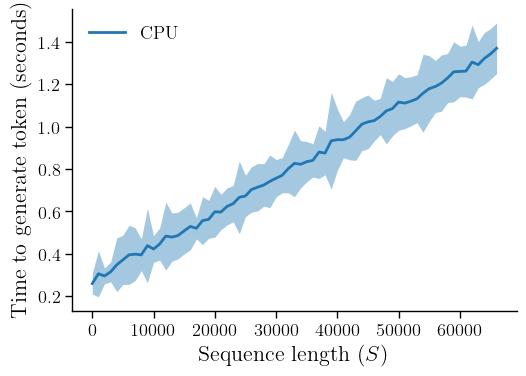

In [16]:
plt.figure(figsize=(5.5, 4))
for logs in ["cpu-bs1-llama-2-7b-Q8_0"]:#, "a100-kv_f16-llama-2-7b-Q8_0"]:
    results = load_results(logs)
    data = results
    truncated_data = truncate(results, remove_prop=0.5)
    model = linear_regression(truncated_data)
    print(model["equation"])
    # proportions = attention_proportion(data, model["intercept"])
    # proportions = {k: v for k, v in proportions.items() if k >= 5000}
    # # print(proportions)
    label = "CPU" if "cpu" in logs else "GPU"
    color = "C0" if "cpu" in logs else "C1"
    plt_config = {
        "scatter": False,
        "xlabel": ("Sequence length ($S$)", {"fontsize": 16}),
        "ylabel": ("Time to generate token (seconds)", {"fontsize": 16}),
        "xticks": range(0, 65000, 10000)
    }
    plot_generation_time(data, color, label, **plt_config)
plt.tight_layout()
plt.legend(loc=2, frameon=False)
# plt.savefig("./time-to-generate-token-llamacpp-gpu.pdf", bbox_inches="tight")
    

[16.905599134433324, 19.623233908948194, 22.168735748669874, 24.557956777996072, 26.804860614724802, 28.92179546506247, 30.91972116033281, 32.808398950131235, 34.59655098999361, 36.29199502281211, 37.90175864160097, 39.43217665615142, 40.888974408312485, 42.27733934611049, 43.6019827427942, 44.867193108399135, 46.076882569773566, 47.23462727585022, 48.34370270724735, 49.40711462450593, 50.42762627077618, 51.40778234735843, 52.34993020009307, 53.25623858794887, 54.12871434970882, 54.96921723834652, 55.77947315387937, 56.56108597285068, 57.31554814506044, 58.04425020486206, 58.748489324560225, 59.42947702060222, 60.08834610887359, 60.726156993096396, 61.3439033597584, 61.94251734390485, 62.52287422227644, 63.08579668348955, 63.63205871907186, 64.16238917405506, 64.67747499137634, 65.17796418045795, 65.66446853693975, 66.13756613756614, 66.597803631619, 67.04569834799399, 67.48174023499524, 67.90639364814041, 68.32009899969063, 68.72327428222358, 69.11631647732985, 69.49960285941224, 69.8

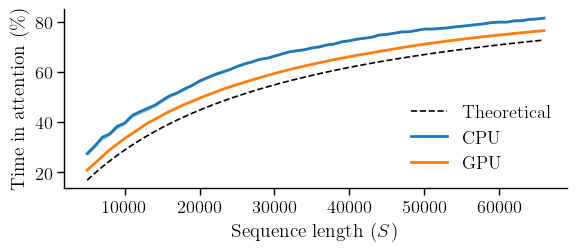

In [36]:
GROUPS = 1
BATCH_SIZE = 1
MODEL_DIMENSION = 4096



def theoretical_time_in_attention(sequence_lengths):
    xs, ys = [], []
    for x in sequence_lengths:
        if x >= 5000:
            rho = x / (GROUPS * MODEL_DIMENSION)
            xs += [x]
            ys += [100 * rho / (rho + 6 / BATCH_SIZE)]

    print(ys)
    plt.plot(xs, ys, label="Theoretical", color="k", linestyle="dashed")
        
    





plt.figure(figsize=(6, 2.75))

theoretical_time_in_attention([*load_results("cpu-bs1-llama-2-7b-Q8_0").keys()])

for logs in ["cpu-bs1-llama-2-7b-Q8_0", "a100-kv_f16-llama-2-7b-Q8_0"]:
    results = load_results(logs)
    data = truncate(results, remove_prop=0.5)
    model = linear_regression(data)
    proportions = attention_proportion(data, model["intercept"])
    proportions = {k: v for k, v in proportions.items() if k >= 5000}
    # print(proportions)
    label = "CPU" if "cpu" in logs else "GPU"
    color = "C0" if "cpu" in logs else "C1"
    plt_config = {
        "scatter": False,
        "xlabel": ("Sequence length ($S$)", {"fontsize": 14}),
        "ylabel": ("Time in attention (\%)", {"fontsize": 14}),
    }
    plot_attention_proportion(proportions, color, label, **plt_config)
plt.tight_layout()




plt.savefig("./time-in-attention-llamacpp.pdf", bbox_inches="tight")


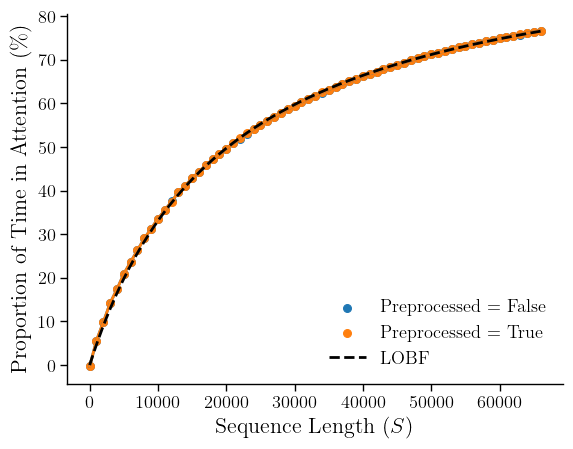

In [18]:
for preprocess in [False, True]:

    data = truncate(results, remove_prop=0.5) if preprocess else results
    model = linear_regression(data)
    proportions = attention_proportion(data, model["intercept"])

    color = {False: "C0", True: "C1"}[preprocess]
    label = f"Preprocessed = {preprocess}"

    plot_attention_proportion(proportions, color, label)

    if preprocess:
        proportions = attention_proportion(model["samples"], model["intercept"])
        plot_attention_proportion(proportions, "k", "LOBF", scatter=False, linestyle="dashed")


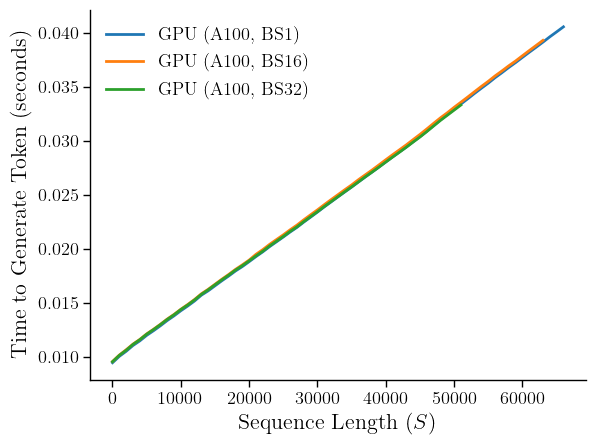

In [19]:
filenames = ["a100-kv_f16-llama-2-7b-Q8_0", "a100-bs16-kv_f16-llama-2-7b-Q8_0-002", "a100-bs32-llama-2-7b-Q8_0"]
for filename, color, label in zip(filenames, ["C0", "C1", "C2"], ["GPU (A100, BS1)", "GPU (A100, BS16)", "GPU (A100, BS32)"]):
    results = load_results(filename)
    results = truncate(results, remove_prop=0.5)
    plot_generation_time(results, color, label, scatter=False)
    # model = linear_regression(results)
    # proportions = attention_proportion(results, model["intercept"])

    # # color = {False: "C0", True: "C1"}[preprocess]
    # # label = f"Preprocessed = {preprocess}"

    # plot_attention_proportion(proportions, color, label)

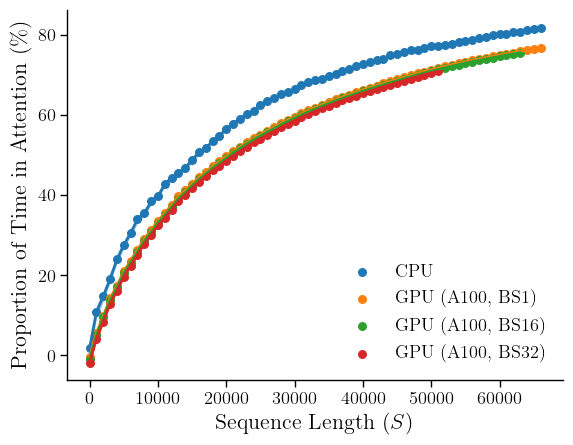

In [20]:
filenames = ["cpu-bs1-llama-2-7b-Q8_0", "a100-kv_f16-llama-2-7b-Q8_0", "a100-bs16-kv_f16-llama-2-7b-Q8_0-002", "a100-bs32-llama-2-7b-Q8_0"]
for filename, color, label in zip(filenames, ["C0", "C1", "C2", "C3"], ["CPU", "GPU (A100, BS1)", "GPU (A100, BS16)", "GPU (A100, BS32)"]):
    results = load_results(filename)
    results = truncate(results, remove_prop=0.5)
    # plot_generation_time(results, color, label)
    model = linear_regression(results)
    proportions = attention_proportion(results, model["intercept"])

    # color = {False: "C0", True: "C1"}[preprocess]
    # label = f"Preprocessed = {preprocess}"

    plot_attention_proportion(proportions, color, label)

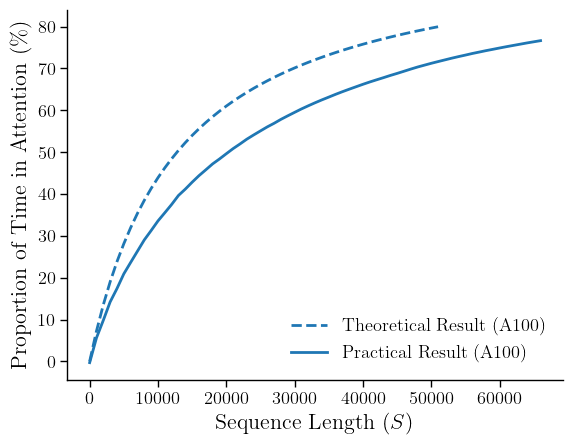

In [21]:
spec = MODELS["Llama-2-7B Q8_0"]
processor = HARDWARE["A100"]
batch_size = 1

theoretical_results = {}
for sequence_length in results:

    attention_properties = get_attention_properties(spec, batch_size, sequence_length)
    transformer_properties = get_transformer_properties(spec, batch_size, sequence_length)

    attention_compute_time = attention_properties["FLOPs"] / processor.flops_per_second
    attention_transfer_time = attention_properties["bytes"] / processor.bytes_per_second
    attention_time = max(attention_compute_time, attention_transfer_time)

    transformer_compute_time = transformer_properties["FLOPs"] / processor.flops_per_second
    transformer_transfer_time = transformer_properties["bytes"] / processor.bytes_per_second
    transformer_time = max(transformer_compute_time, transformer_transfer_time)

    theoretical_results[sequence_length] = [100 * attention_time / transformer_time]


plot_attention_proportion(theoretical_results, "C0", "Theoretical Result (A100)", scatter=False, linestyle="dashed")

results = load_results("a100-kv_f16-llama-2-7b-Q8_0")
data = truncate(results, remove_prop=0.5)
model = linear_regression(data)
proportions = attention_proportion(data, model["intercept"])
plot_attention_proportion(proportions, "C0", "Practical Result (A100)", scatter=False)


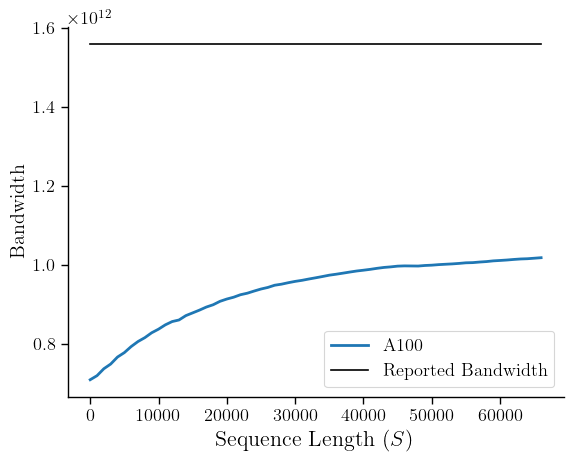

In [22]:
spec = MODELS["Llama-2-7B Q8_0"]
processor = HARDWARE["A100"]

bandwidth_results = {}
for sequence_length in results:

    transformer_properties = get_transformer_properties(spec, 1, sequence_length)
    transformer_bytes = transformer_properties["bytes"]
    transformer_bandwidth = transformer_bytes / np.mean(results[sequence_length])
    bandwidth_results[sequence_length] = [transformer_bandwidth]

plot_attention_proportion(bandwidth_results, "C0", "A100", scatter=False, ylabel="Bandwidth")
_ = plt.plot([min(results), max(results)], [processor.bytes_per_second, processor.bytes_per_second], color="k", label="Reported Bandwidth")
_ = plt.legend()
